In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import math
import re

%pip install advertools
import advertools as adv

Note: you may need to restart the kernel to use updated packages.


In [17]:
# Read in text data

reddit_data = pd.read_csv("/Users/eugen/Desktop/Work/BrainStation/Suicide Project/Suicide_Detection.csv", index_col = 0).reset_index(drop=True)
reddit_data.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## 1. Data Pre-processing and Cleaning

In [18]:
print(f"Dataset has {reddit_data.shape[0]} and {reddit_data.shape[1]} columns")

Dataset has 232074 and 2 columns


In [19]:
reddit_data.info() #no missing values and both columns are in the right format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [ ]:
reddit_data['class'] = reddit_data['class'].map({'suicide': 1, 'non-suicide':0}) #mapping 1 to suicide posts and 0 to non-suicide posts
#plotting the propotion of suicide vs non-suicide posts
plt.bar(reddit_data['class'])

,text,class,number_chars,number_words,unique_words,num_questions
0,Ex Wife Threatening SuicideRecently I left my ...,1,715,143,99,2
1,Am I weird I don't get affected by compliments...,0,138,27,24,0
2,Finally 2020 is almost over... So I can never ...,0,129,26,25,0
3,i need helpjust help me im crying so hard,1,41,9,9,0
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,2426,438,254,3


<AxesSubplot:xlabel='class', ylabel='count'>

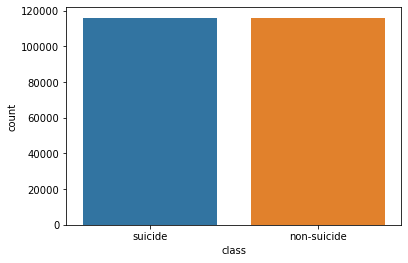

In [12]:
sns.countplot(x='class', data=reddit_data) #proportion of suicide vs nono-suicide posts

The text column contains reddit posts for the users; however, it is very messy. We need to thoroughly clean each text because our analysis and model performance will depend on it. 

In the above snippet, we have:
- Contractions: e.g. I'm
- Puncuations: e.g. ", !
- Emojis
- Numbers.

In the part below, we are going to expand contractions, lower case all letters, remove punctuations

In [14]:
#lowercase all text before expanding contractions
reddit_data_cleaned = reddit_data["text"].apply(lambda x: x.lower())

### 1.1. Expand contractions

In [15]:
# dictionary of common English contractions and their full meaning
contractions_dict = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"how're": "how are",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

# function to expand contractions
def expand_contractions(text: str, contraction_mapping: dict) -> str:
    """
    Takes in a string and a dictionary of contractions and their expansions 
    Returns an expanded string. 
    """
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL) 
                                      #re.IGNORECASE = disables case-sensitive matching and enales unicode matching, 
                                      #re.DOTALL = dot matches all characters
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [ ]:
re_pattern = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text: str, contractions_dict=contractions_dict) -> str:
    """
    Takes in a string and a dictionary of contractions and their expansions 
    Returns an expanded string. 
    """
    def replace(match):
        return contractions_dict[match.group(0)]

    return re_pattern.sub(replace, text)
  
# expnd text contractions in the dataset
reddit_data['text'] = reddit_data['text'].apply(lambda x: expand_contractions(x))

In [58]:
# remove contractions from dataset
reddit_data['clean_text'] = reddit_data['text'].apply(lambda x: expand_contractions(x, contractions_dict))
reddit_data.head()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
#which specific contraction methods to use? 
#may be compare different contraction methods and their accuracy before?

#using a dictionary has disadvantages. e.g. Jack's wine will be converted to Jack is wine. It doesn't care about the context of the word. 

Footnote: contraction dictionary from [Analytics Vidya](https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/)

In [23]:
#finding the contractions in our dataset's text
pattern = r""" (?x)
        


"""

In [10]:
# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
    return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
reddit_data['text']= reddit_data['text'].apply(lambda x:expand_contractions(x))

TypeError: expected string or bytes-like object

In [9]:
reddit_data.head()

,text,class
0,None,suicide
1,None,non-suicide
2,None,non-suicide
3,None,suicide
4,None,suicide


In [ ]:
## feature enginneering
def count_chars(text):
    """
    Takes in a string of text and counts the number of characters
    """
    return len(text)

def count_words(text):
    """
    Takes in a string of text and counts the number of words
    """
    return len(text.split())

def unique_words(text):
    """
    Takes in a string of text and counts the number of unique words
    """
    return(len(set(text.split())))

def question_counts(text):
    """
    Takes in a string of text and counts the number question marks
    """
    return adv.extract_questions(text)['question_mark_counts'][0]

def url(text):
    """
    Takes in a string of text, determines if string starts with 'http', then counts it 
    as a link
    """
    url_count = 0

    text = text.split()
    for i in text:
        if i.startswith('http'):
            url_count += url_count
    return url_count


In [ ]:
reddit_data['number_chars'] = reddit_data['text'].apply(lambda x:count_chars(x))
reddit_data['number_words'] = reddit_data['text'].apply(lambda x:count_words(x))
reddit_data['unique_words'] = reddit_data['text'].apply(lambda x:unique_words(x))
reddit_data['num_questions'] = reddit_data['text'].apply(lambda x:question_counts(x))
reddit_data['url_count'] = reddit_data['text'].apply(lambda x:url(x))

reddit_data.head()

,text,class,number_chars,number_words,unique_words,num_questions,url_count
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,715,143,99,2,0
1,Am I weird I don't get affected by compliments...,non-suicide,138,27,24,0,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,129,26,25,0,0
3,i need helpjust help me im crying so hard,suicide,41,9,9,0,0
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,2426,438,254,3,0


In [ ]:
reddit_data.describe()

,number_chars,number_words,unique_words,num_questions,url_count
count,232074.000000,232074.000000,232074.000000,232074.000000,232074.0
mean,689.639736,131.925235,80.065910,0.731254,0.0
std,1156.334007,217.476787,93.782047,23.318268,0.0
min,3.000000,1.000000,1.000000,0.000000,0.0
25%,138.000000,26.000000,23.000000,0.000000,0.0
50%,315.000000,60.000000,47.000000,0.000000,0.0
75%,801.000000,155.000000,104.000000,1.000000,0.0
max,40297.000000,9684.000000,5010.000000,8209.000000,0.0


In [ ]:
reddit_data.drop('url_count', axis = 1, inplace=True)

In [ ]:
reddit_data.columns[2:]

Index(['number_chars', 'number_words', 'unique_words', 'num_questions'], dtype='object')

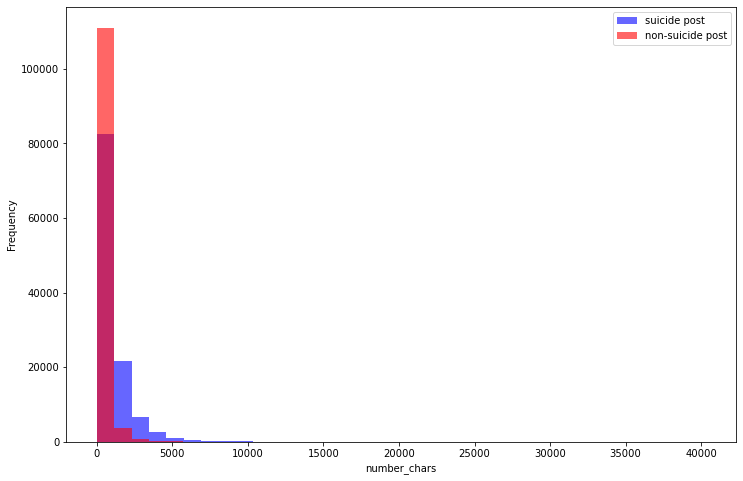

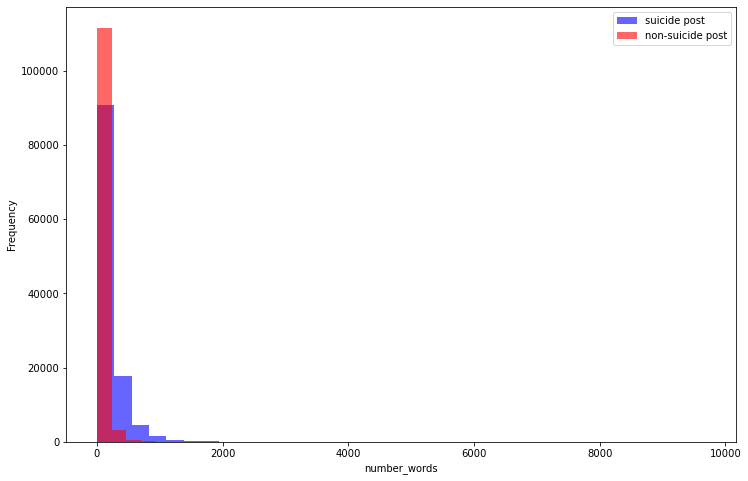

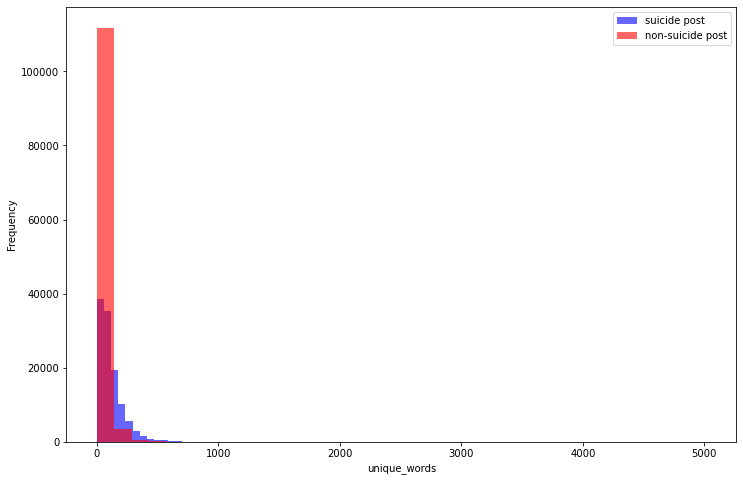

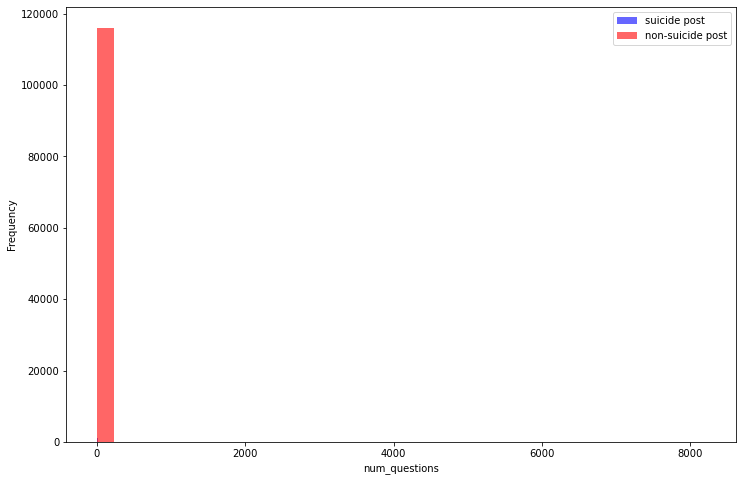

In [ ]:
for col in reddit_data.columns[2:]:
    plt.figure(figsize=(12, 8))
    reddit_data[reddit_data['class']=="suicide"][col].plot(bins=35, kind='hist', color='blue', label='suicide post', alpha=0.6)
    reddit_data[reddit_data['class']=="non-suicide"][col].plot(bins=35, kind='hist', color='red', label='non-suicide post', alpha=0.6)
    plt.xlabel(col)
    plt.legend()
    